In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from math import sqrt, ceil
from scipy.stats import linregress    
import libraries as lib
import math 
    

In [3]:
#Lees de GPS data in

# Helper function to convert NMEA latitude/longitude to decimal degrees
def convert_to_decimal_degrees(value, direction):
    degrees = int(value) // 100
    minutes = value - (degrees * 100)
    decimal = degrees + (minutes / 60)
    
    if direction in ['S', 'W']:
        decimal = -decimal
    
    return decimal

# Function to read GPS data from a text file and convert to a DataFrame
def lees_gps_data(filepath):
    """Read GPS data from a text file and convert to a DataFrame."""
    timestamps = []
    latitudes = []
    lat_directions = []
    longitudes = []
    lon_directions = []
    hoogtes = []
    speeds = []
    
    with open(filepath, 'r') as file:
        for regel in file:
            parts = regel.split(',')
            if regel.startswith('$GPRMC'):
                # Extract time and speed from GPRMC sentence
                if len(parts) > 7:
                    timestamp = parts[1]
                    speed = parts[7]  # Speed in knots
                    timestamps.append(timestamp)
                    try:
                        speed_kmh = (float(speed) * 1.852) / 3.6  # Convert knots to m/s
                        speeds.append(speed_kmh)
                    except ValueError:
                        speeds.append(None)

            elif regel.startswith('$GPGGA'):
                # Extract latitude, longitude, and altitude from GPGGA sentence
                if len(parts) > 9:
                    latitude = parts[2]
                    lat_direction = parts[3]
                    longitude = parts[4] 
                    lon_direction = parts[5]
                    altitude = parts[9]
                    
                    # Append raw values for conversion later
                    try:
                        latitude = float(latitude)
                        latitudes.append(latitude)
                        lat_directions.append(lat_direction)
                    except ValueError:
                        latitudes.append(None)
                        lat_directions.append(None)
                    
                    try:
                        longitude = float(longitude)
                        longitudes.append(longitude)
                        lon_directions.append(lon_direction)
                    except ValueError:
                        longitudes.append(None)
                        lon_directions.append(None)
                    
                    # Convert altitude to float
                    try:
                        altitude = float(altitude)
                        hoogtes.append(altitude)
                    except ValueError:
                        hoogtes.append(None)
    
    # Check if all lists have the same length
    max_length = max(len(timestamps), len(latitudes), len(longitudes), len(hoogtes), len(speeds))
    
    # Make sure all lists have the same length by appending None to the shorter ones
    timestamps.extend([None] * (max_length - len(timestamps)))
    latitudes.extend([None] * (max_length - len(latitudes)))
    lat_directions.extend([None] * (max_length - len(lat_directions)))
    longitudes.extend([None] * (max_length - len(longitudes)))
    lon_directions.extend([None] * (max_length - len(lon_directions)))
    hoogtes.extend([None] * (max_length - len(hoogtes)))
    speeds.extend([None] * (max_length - len(speeds)))
    
    # Construct DataFrame
    data = {
        'timestamp': timestamps,
        'latitude': latitudes,
        'lat_direction': lat_directions,
        'longitude': longitudes,
        'lon_direction': lon_directions,
        'hoogte': hoogtes,
        'speed_m/s': speeds
    }
    
    df = pd.DataFrame(data)
    
    # Filter out rows where latitude or longitude are missing
    df = df.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)
    
    # Convert latitude and longitude columns to decimal degrees
    df['latitude'] = df.apply(lambda row: convert_to_decimal_degrees(float(row['latitude']), row['lat_direction']), axis=1)
    df['longitude'] = df.apply(lambda row: convert_to_decimal_degrees(float(row['longitude']), row['lon_direction']), axis=1)
    
    return df

# Set file path
file_path = "C:/Users/qvled/OneDrive - HvA/Clean_Mobility_Files/H2A/Data voor hoogteprofiel.txt"

# Read GPS data
df = lees_gps_data(file_path)

# Print the resulting DataFrame
df


,timestamp,latitude,lat_direction,longitude,lon_direction,hoogte,speed_m/s
0,063448.30,43.771393,N,-0.042098,W,99.5,0.038583
1,063448.40,43.771393,N,-0.042098,W,99.5,0.026237
2,063448.50,43.771393,N,-0.042098,W,99.4,0.035497
3,063448.60,43.771393,N,-0.042098,W,99.5,0.073051
4,063448.70,43.771393,N,-0.042098,W,99.4,0.064820
...,...,...,...,...,...,...,...
46568,None,43.771202,N,-0.041941,W,96.0,NaN
46569,None,43.771202,N,-0.041941,W,96.0,NaN
46570,None,43.771202,N,-0.041941,W,96.1,NaN
46571,None,43.771202,N,-0.041941,W,96.1,NaN


In [4]:
#Functies voor het filter

def calculate_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2)

def find_nearest_index(df, target_lon, target_lat):
    distances = df.apply(lambda row: calculate_distance(row['latitude'], row['longitude'], target_lat, target_lon), axis=1)
    return distances.idxmin()

def filter_track_data(df, start_lon, start_lat, end_lon, end_lat):
    start_index = find_nearest_index(df, start_lon, start_lat)
    end_index = find_nearest_index(df, end_lon, end_lat)
    
    # Zorg ervoor dat de start_index voor de end_index komt
    if start_index > end_index:
        start_index, end_index = end_index, start_index
    
    return df.iloc[start_index:end_index + 1]


In [5]:
#Filter vanaf het moment dat de auto de baan opgaat en wanneer die er weer afgaat.

# Definieer de coördinaten voor het start- en eindpunt
start_lon = -0.0446
start_lat = 0.00095 + 4.3771e1
end_lon = -0.039925
end_lat = 0.000300 + 4.3771e1

# Veronderstel dat 'df' je DataFrame is met de relevante data
filtered_df = filter_track_data(df, start_lon, start_lat, end_lon, end_lat)

# Print het gefilterde DataFrame om te controleren
filtered_df
#43.767914, -0.035855

,timestamp,latitude,lat_direction,longitude,lon_direction,hoogte,speed_m/s
22340,071203.60,43.771951,N,-0.044597,W,102.0,5.597156
22341,071203.70,43.771954,N,-0.044603,W,102.0,5.624421
22342,071203.80,43.771955,N,-0.044609,W,102.0,5.633167
22343,071203.90,43.771958,N,-0.044616,W,102.0,5.650143
22344,071204.00,43.771960,N,-0.044622,W,102.0,5.655288
...,...,...,...,...,...,...,...
42943,074720.40,43.771037,N,-0.040149,W,98.1,8.270209
42944,074720.50,43.771032,N,-0.040142,W,98.1,8.298503
42945,074720.60,43.771027,N,-0.040135,W,98.1,8.276382
42946,074720.70,43.771022,N,-0.040127,W,98.1,8.287700


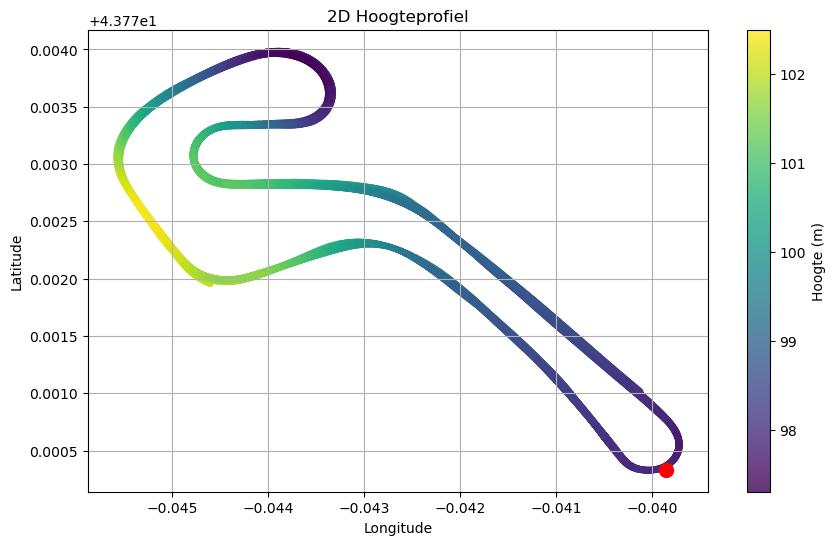

In [6]:
#Plot om te checken of het is gelukt en ref met maps
#Het is gelukt.


# Definieer een functie voor een 2D-plot
def plot_2d_height_profile(latitudes, longitudes, hoogtes):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(longitudes, latitudes, c=hoogtes, cmap='viridis', s=10, alpha=0.8)
    plt.scatter(-0.039853, 43.770328, color='red', s=100, marker='o', label='Specifiek punt')
    plt.colorbar(scatter, label='Hoogte (m)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('2D Hoogteprofiel')
    plt.grid(True)
    plt.show()

# Voorbeeld dataframe (hier kun je je eigen gefilterde data inladen)
# Gebruik de functie met de gefilterde data
plot_2d_height_profile(filtered_df['latitude'], filtered_df['longitude'], filtered_df['hoogte'])


In [7]:
#Filter voor de rechte stukken.

# Set initial flag and empty list
gevonden = False
rechtestuk_rijen_hoogte = []

# Define the coordinates for the two rectangular areas
lat_min, lat_max = 7e-5 + 4.37724e1, 8.6e-5 + 4.37724e1
lon_min, lon_max = -0.04224, -0.04221

lat_min2, lat_max2 = 70e-5 + 4.377e1, 74e-5 + 4.377e1
lon_min2, lon_max2 = -0.03982, -0.03975


# Iterate over each row in the DataFrame (replace df with your actual DataFrame)
for i in range(len(filtered_df)):
    lat = filtered_df['latitude'].iloc[i]  # Latitude of the i-th row
    lon = filtered_df['longitude'].iloc[i]  # Longitude of the i-th row
   
    # Check if the point is within the first box
    if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
        if not gevonden:  # Append only the first time a point is found in the first box
            rechtestuk_rijen_hoogte.append(i)
            gevonden = True  # Set 'gevonden' flag to True

    # Check if the point is within the second box after finding a point in the first box
    if gevonden and lat_min2 <= lat <= lat_max2 and lon_min2 <= lon <= lon_max2:
        rechtestuk_rijen_hoogte.append(i)
        gevonden = False  # Reset 'gevonden' flag to False after processing the second box
        
    #Optionally, you can print out each step to debug
    # print(f"i: {i}, lat: {lat}, lon: {lon}, gevonden: {gevonden}, rechtestuk_rijen: {rechtestuk_rijen}")

# Convert the list to a numpy array if needed

# Print the results
print("Indices of points in the two boxes:", rechtestuk_rijen_hoogte)


Indices of points in the two boxes: [962, 1282, 3058, 3356, 5066, 5370, 7068, 7372, 9238, 9561, 11378, 11698, 13580, 13908, 15782, 16107, 18039, 18370, 20317]


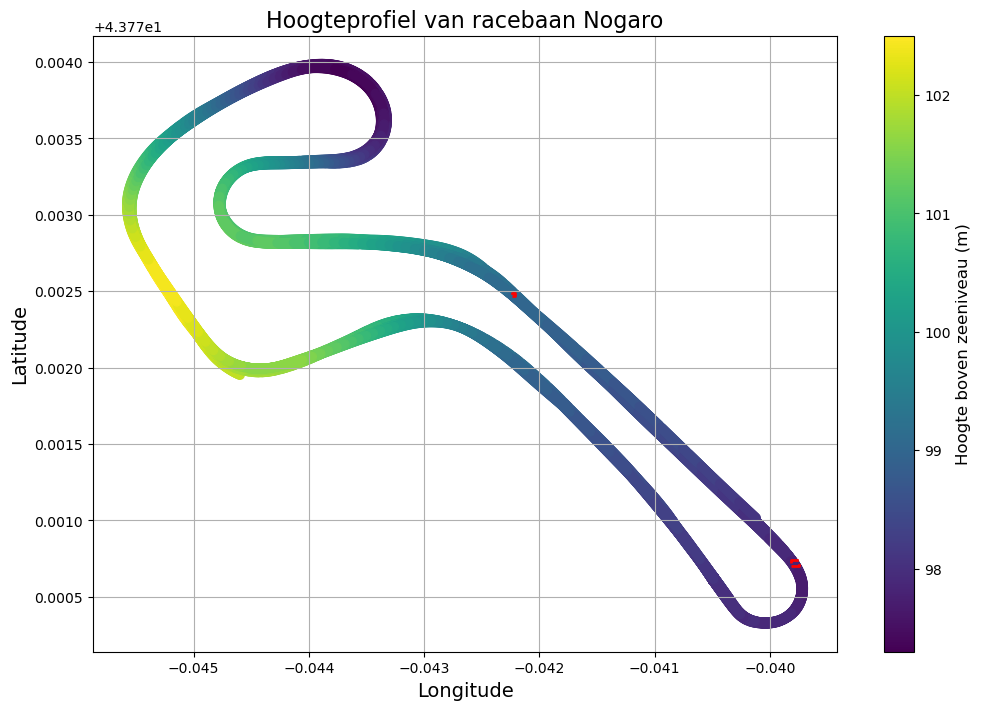

In [8]:
#Check of het is gelukt met de rechte stukken
#Het is gelukt


import matplotlib.pyplot as plt

def plot_hoogteprofiel_2d(latitudes, longitudes, hoogtes):
    # Increase figure size by setting the figsize
    fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height as needed
    scatter = ax.scatter(longitudes, latitudes, c=hoogtes, cmap='viridis', marker='o')
    ax.set_title('Hoogteprofiel van racebaan Nogaro', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    
    # Create the colorbar
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Hoogte boven zeeniveau (m)', fontsize=12)

    # Plot the rectangular boundaries
    plt.plot(
        [lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color='red', linestyle='--', linewidth=2, label="Boundary Square")

    plt.plot(
        [lon_min2, lon_max2, lon_max2, lon_min2, lon_min2],
        [lat_min2, lat_min2, lat_max2, lat_max2, lat_min2],
        color='red', linestyle='--', linewidth=2, label="Boundary Square")

    for i in range(len(latitudes)):
        lat = latitudes.iloc[i]
        lon = longitudes.iloc[i]
        #plt.text(lon, lat, str(i), fontsize=8, color='black')

    # Enable grid
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Assuming `df` is your DataFrame with columns: 'latitude', 'longitude', and 'hoogte'
plot_hoogteprofiel_2d(filtered_df['latitude'], filtered_df['longitude'], filtered_df['hoogte'])


In [9]:
#Check afstand tussen begin en eind rechte stuk
import math

# Jouw haversine functie
def haversine(lat1, lon1, lat2, lon2, radius=6371000):  # Radius in meters
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Compute differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Distance in meters
    distance = radius * c
    return distance

# Omzetten van 'latitude' en 'longitude' naar correcte waarden (rekening houdend met N/S en E/W)
def correct_coordinates(lat, lat_dir, lon, lon_dir):
    if lat_dir == 'S':
        lat = -lat
    if lon_dir == 'W':
        lon = -lon
    return lat, lon

# Functie om de afstand te berekenen tussen twee rijen in de DataFrame
def calculate_distance_between_rows(df, row_index1, row_index2):
    # Haal de coördinaten en richting op voor de twee rijen
    lat1, lon1 = correct_coordinates(
        df.loc[row_index1, 'latitude'], df.loc[row_index1, 'lat_direction'],
        df.loc[row_index1, 'longitude'], df.loc[row_index1, 'lon_direction']
    )
    lat2, lon2 = correct_coordinates(
        df.loc[row_index2, 'latitude'], df.loc[row_index2, 'lat_direction'],
        df.loc[row_index2, 'longitude'], df.loc[row_index2, 'lon_direction']
    )
    
    # Bereken de afstand met de haversine functie
    distance = haversine(lat1, lon1, lat2, lon2)
    return distance

# Voorbeeld van hoe de functie te gebruiken
# Stel dat filtered_df al je DataFrame is
row_index1 = 962+22340  # Vervang dit door de index van de eerste rij
row_index2 = 1282+22340  # Vervang dit door de index van de tweede rij

# Bereken de afstand tussen de twee punten
afstand = calculate_distance_between_rows(filtered_df, row_index1, row_index2)
print(f"De afstand tussen rij {row_index1} en rij {row_index2} is: {afstand} meter")


De afstand tussen rij 23302 en rij 23622 is: 275.5040146481721 meter


In [10]:
#Bereken delta x en delta h overal en laat deze in een aparte kolom sommeren
# Jouw haversine functie
def haversine(lat1, lon1, lat2, lon2, radius=6371000):  # Radius in meters
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Compute differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Distance in meters
    distance = radius * c
    return distance

# Omzetten van 'latitude' en 'longitude' naar correcte waarden (rekening houdend met N/S en E/W)
def correct_coordinates(lat, lat_dir, lon, lon_dir):
    if lat_dir == 'S':
        lat = -lat
    if lon_dir == 'W':
        lon = -lon
    return lat, lon

# Functie om de afstand te berekenen tussen twee rijen in de DataFrame
def calculate_distance_between_rows(df, row_index1, row_index2):
    # Haal de coördinaten en richting op voor de twee rijen
    lat1, lon1 = correct_coordinates(
        df.loc[row_index1, 'latitude'], df.loc[row_index1, 'lat_direction'],
        df.loc[row_index1, 'longitude'], df.loc[row_index1, 'lon_direction']
    )
    lat2, lon2 = correct_coordinates(
        df.loc[row_index2, 'latitude'], df.loc[row_index2, 'lat_direction'],
        df.loc[row_index2, 'longitude'], df.loc[row_index2, 'lon_direction']
    )
    
    # Bereken de afstand met de haversine functie
    distance = haversine(lat1, lon1, lat2, lon2)
    return distance

# Functie om hoogteverschil te berekenen tussen twee rijen
def calculate_height_difference(df, row_index1, row_index2):
    hoogte1 = df.loc[row_index1, 'hoogte']
    hoogte2 = df.loc[row_index2, 'hoogte']
    return hoogte2 - hoogte1

# Bereken de afstand en hoogteverschil voor elke rij van 23302 tot en met 23622
rows = range(25271, 25711)
afstanden = []
hoogteverschillen = []

for i in range(len(rows) - 1):
    row_index1 = rows[i]
    row_index2 = rows[i + 1]
    
    # Bereken afstand en hoogteverschil
    afstand = calculate_distance_between_rows(filtered_df, row_index1, row_index2)
    hoogteverschil = calculate_height_difference(filtered_df, row_index1, row_index2)
    
    afstanden.append(afstand)
    hoogteverschillen.append(hoogteverschil)

# Maak een DataFrame met de resultaten
hoogte_vs_afstand = pd.DataFrame({
    'afstand': afstanden,
    'hoogteverschil': hoogteverschillen
})

# Voeg cumulatieve afstand en cumulatief hoogteverschil toe
hoogte_vs_afstand['cumulatieve_afstand'] = hoogte_vs_afstand['afstand'].cumsum()
hoogte_vs_afstand['cumulatief_hoogteverschil'] = hoogte_vs_afstand['hoogteverschil'].cumsum()

# Print de DataFrame
hoogte_vs_afstand


,afstand,hoogteverschil,cumulatieve_afstand,cumulatief_hoogteverschil
0,0.843887,0.0,0.843887,0.0
1,0.843276,0.0,1.687162,0.0
2,0.856655,0.0,2.543817,0.0
3,0.843887,0.0,3.387704,0.0
4,0.843276,-0.1,4.230979,-0.1
...,...,...,...,...
434,0.807888,0.0,401.889518,-2.7
435,0.802661,0.0,402.692179,-2.7
436,0.819808,0.0,403.511987,-2.7
437,0.792783,0.0,404.304770,-2.7


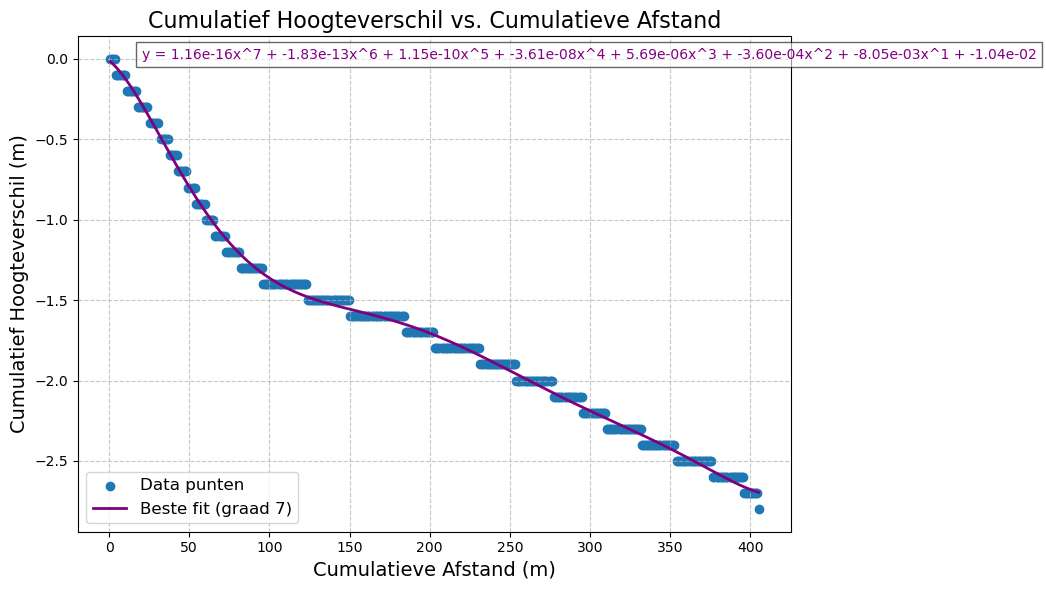

y = 1.16e-16x^7 + -1.83e-13x^6 + 1.15e-10x^5 + -3.61e-08x^4 + 5.69e-06x^3 + -3.60e-04x^2 + -8.05e-03x^1 + -1.04e-02


In [11]:
#hoogte vs afstand met fitvergelijking
hoogte_vs_afstand = pd.DataFrame(hoogte_vs_afstand)

# Data voor de plot
x = hoogte_vs_afstand['cumulatieve_afstand']
y = hoogte_vs_afstand['cumulatief_hoogteverschil']

# Zevende graads polynoomfit
degree = 7
coefficients_7 = np.polyfit(x, y, degree)
polynomial_7 = np.poly1d(coefficients_7)
y_fit_7 = polynomial_7(x)

# Plot de scatter en de fit
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data punten')
plt.plot(x, y_fit_7, color='purple', linestyle='-', linewidth=2, label=f'Beste fit (graad {degree})')

# Formule van de polynoomfit genereren
fit_equation_7 = "y = " + " + ".join(
    [f"{coef:.2e}x^{degree - i}" if degree - i > 0 else f"{coef:.2e}" for i, coef in enumerate(coefficients_7)]
)

# Formule toevoegen aan de plot
plt.text(
    0.05 * max(x),
    0.85 * max(y),
    fit_equation_7,
    color='purple',
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.6)
)

# Labels en titel
plt.xlabel('Cumulatieve Afstand (m)', fontsize=14)
plt.ylabel('Cumulatief Hoogteverschil (m)', fontsize=14)
plt.title('Cumulatief Hoogteverschil vs. Cumulatieve Afstand', fontsize=16)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='lower left')
plt.tight_layout()
plt.show()

# Print de formule
print(fit_equation_7)


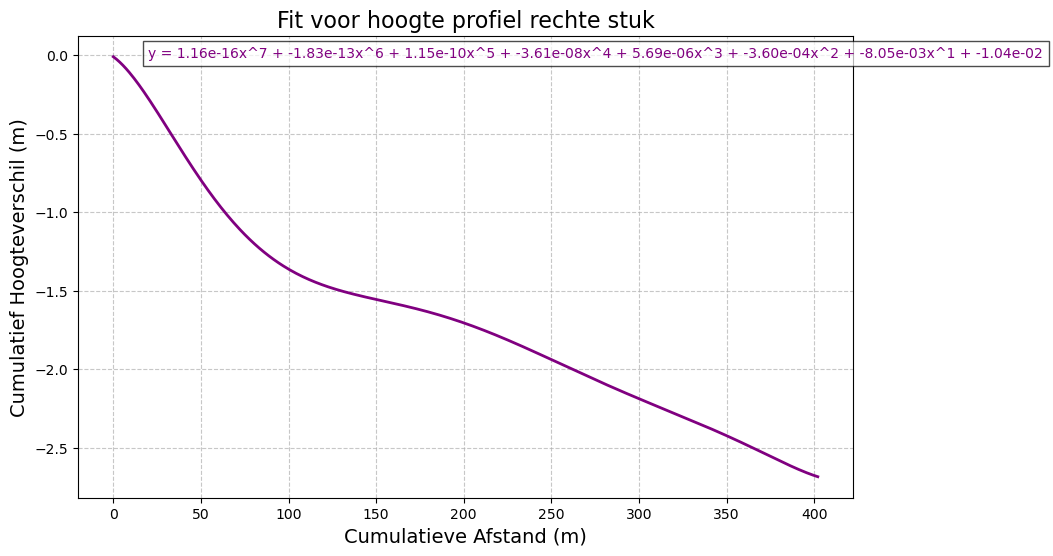

In [12]:
#formule voor h, pas x_fit aan om het aantal datapunten te veranderen
x_fit = np.linspace(0, 402, 440)
h = polynomial_7(x_fit)

# Plot the fit equation from x = 0 to x = 275
plt.figure(figsize=(10, 6))
plt.plot(x_fit, h, color='purple', linestyle='-', linewidth=2, label=f'Polynoom fit (graad {degree})')
plt.grid(visible=True, linestyle='--', alpha=0.7)
#Add fit equation to the plot
plt.text(
    0.05 * max(x_fit),
    0.85 * max(y_fit_7),
    fit_equation_7,
    color='purple',
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.7)
)
plt.xlabel('Cumulatieve Afstand (m)', fontsize=14)
plt.ylabel('Cumulatief Hoogteverschil (m)', fontsize=14)
plt.title('Fit voor hoogte profiel rechte stuk', fontsize=16)

plt.show()

In [13]:
#Inladen motordriver

directory = "C:/Users\qvled\OneDrive - HvA\Logfiles\H2A/2023/Nogaro/20230525_h2a_poging1/0002/"
file_motordriver ="5.csv"
data_file_motordriver = lib.DataInladenMotorDriver(f'{directory}{file_motordriver}')

#Fix de longitude
data_file_motordriver["GPS longitude, in graden"] = data_file_motordriver["GPS longitude, in graden"]* -1

#Voeg wielsnelheid in m/s toe
data_file_motordriver.loc[:, "Wielsnelheid, in m/s"] = data_file_motordriver["Wielsnelheid, in km/h"] / 3.6

data_file_motordriver.loc[:, "GPS speed, in m/s"] = data_file_motordriver["GPS speed, in km/h"] / 3.6

data_file_motordriver

,Datalogger port,"Dataloggertijd, in s",Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning aan de ingang van motordriver (V),Stroom door de ingang van motordriver (A),...,"Toestand cruise control2-knop (aan=1, uit=0)",Tijdstip laatste verandering cruise control2-knop,"GPS longitude, in graden","GPS latitude, in graden",GPS direction,"GPS speed, in km/h","GPS time, in seconden sinds het begin van de huidige GPS-week",Checksum,"Wielsnelheid, in m/s","GPS speed, in m/s"
0,5,252.6246,03|04,0.0060,2.725,-0.003,-0.1,0,3.034,-0.000,...,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,1.085278,NaN
1,5,252.6305,03|04,0.0118,4.996,-0.006,-0.1,0,5.562,0.008,...,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.592500,NaN
2,5,252.6362,03|04,0.0176,7.028,-0.008,-0.2,0,7.823,0.018,...,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.421667,NaN
3,5,252.6420,03|04,0.0234,8.845,-0.010,-0.2,0,9.846,0.028,...,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.335278,NaN
4,5,252.6478,03|04,0.0292,10.471,-0.010,-0.2,0,11.655,0.033,...,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.283333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496050,5,6919.3279,03|04,3277.5222,0.039,0.114,0.0,181490,9.762,0.111,...,0,3073.986,-2.4680,4346.2451,228.6,1.5,81836.6,NaN,0.000000,0.416667
496051,5,6919.3363,03|04,3277.5308,0.039,0.122,0.0,181490,9.371,0.114,...,0,3073.986,-2.4680,4346.2451,228.6,1.5,81836.6,NaN,0.000000,0.416667
496052,5,6919.3448,03|04,3277.5393,0.040,0.129,0.0,181490,8.970,0.119,...,0,3073.986,-2.4680,4346.2451,228.6,1.5,81836.6,NaN,0.000000,0.416667
496053,5,6919.3533,03|04,3277.5479,0.040,0.141,0.0,181490,8.543,0.124,...,0,3073.986,-2.4680,4346.2451,228.6,1.5,81836.6,NaN,0.000000,0.416667


In [14]:
#Filter motordriver data van race begin tot race einde

def filter_track_data_with_start_and_end(data_file_motordriver, start_row, end_row):
    """
    Filter de data handmatig vanaf een opgegeven startrij tot een opgegeven eindrij.
    
    Parameters:
        data_file_motordriver (DataFrame): Het originele DataFrame.
        start_row (int): Het indexnummer van de rij waarmee het filteren moet beginnen.
        end_row (int): Het indexnummer van de rij waarmee het filteren moet eindigen.
        
    Returns:
        DataFrame: Het gefilterde DataFrame vanaf start_row tot end_row.
    """
    # Zorg ervoor dat de start_row en end_row binnen de geldige indexrange vallen
    if start_row < 0 or start_row >= len(data_file_motordriver):
        raise ValueError("De opgegeven start-row valt buiten de geldige indexrange.")
    if end_row < 0 or end_row >= len(data_file_motordriver):
        raise ValueError("De opgegeven end-row valt buiten de geldige indexrange.")
    
    # Controleer dat start_row kleiner of gelijk is aan end_row
    if start_row > end_row:
        raise ValueError("De start-row moet kleiner zijn dan of gelijk zijn aan de eind-row.")
    
    # Filter het DataFrame tussen start_row en end_row
    return data_file_motordriver.iloc[start_row:end_row + 1]

# Handmatige specificatie van start- en eindrij
start_row = 223257  # Begin vanaf rij 223257
end_row = 479444    # Eindig bij rij 250000

# Filter de data
filtered_motordriver = filter_track_data_with_start_and_end(data_file_motordriver, start_row, end_row)

# Print het gefilterde DataFrame
filtered_motordriver


,Datalogger port,"Dataloggertijd, in s",Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning aan de ingang van motordriver (V),Stroom door de ingang van motordriver (A),...,"Toestand cruise control2-knop (aan=1, uit=0)",Tijdstip laatste verandering cruise control2-knop,"GPS longitude, in graden","GPS latitude, in graden",GPS direction,"GPS speed, in km/h","GPS time, in seconden sinds het begin van de huidige GPS-week",Checksum,"Wielsnelheid, in m/s","GPS speed, in m/s"
223257,5,4540.1490,03|04,898.7554,2.689,9.883,36.8,-1340,31.898,1.225,...,0,0.000,-2.4802,4346.2552,333.0,1.7,73857.4,NaN,0.355278,0.472222
223258,5,4540.1571,03|04,898.7634,3.127,10.037,43.2,-1340,31.894,1.325,...,0,0.000,-2.4802,4346.2553,333.0,1.7,73857.4,NaN,0.354167,0.472222
223259,5,4540.1652,03|04,898.7716,3.702,10.203,51.8,-1339,31.889,1.454,...,0,0.000,-2.4802,4346.2553,339.2,1.7,73857.6,NaN,0.371389,0.472222
223260,5,4540.1734,03|04,898.7796,3.541,10.329,50.1,-1339,31.889,1.499,...,0,0.000,-2.4802,4346.2553,339.2,1.7,73857.6,NaN,0.389444,0.472222
223261,5,4540.1815,03|04,898.7878,3.242,10.222,46.2,-1339,31.894,1.391,...,0,0.000,-2.4802,4346.2553,339.2,1.7,73857.6,NaN,0.406944,0.472222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479440,5,6774.8277,03|04,3133.0471,0.021,-0.085,-0.0,181490,30.445,-0.039,...,0,3073.986,-2.4679,4346.2367,323.4,3.0,81612.0,NaN,1.195278,0.833333
479441,5,6774.8364,03|04,3133.0559,0.020,-0.084,-0.0,181490,30.445,-0.042,...,0,3073.986,-2.4679,4346.2367,323.4,3.0,81612.0,NaN,1.176111,0.833333
479442,5,6774.8451,03|04,3133.0647,0.020,-0.084,-0.0,181490,30.445,-0.045,...,0,3073.986,-2.4679,4346.2367,323.4,3.0,81612.0,NaN,1.141389,0.833333
479443,5,6774.8538,03|04,3133.0735,0.020,-0.083,-0.0,181490,30.445,-0.048,...,0,3073.986,-2.4679,4346.2367,323.4,3.0,81612.0,NaN,1.112500,0.833333


In [15]:
# Functie om graden minuten naar decimale graden om te rekenen
def convert_to_decimal_degrees(value):
    if pd.isna(value):
        return None
    degrees = int(value // 100)  # De gehele gradenwaarde
    minutes = value % 100  # De minutenwaarde
    decimal_degrees = degrees + (minutes / 60)
    return decimal_degrees

# Pas de functie toe op latitude en longitude kolommen, waarbij NaN-waarden worden behouden
filtered_motordriver['GPS latitude, in graden'] = filtered_motordriver['GPS latitude, in graden'].apply(lambda x: convert_to_decimal_degrees(x) if pd.notna(x) else None)
filtered_motordriver['GPS longitude, in graden'] = filtered_motordriver['GPS longitude, in graden'].apply(lambda x: -convert_to_decimal_degrees(abs(x)) if pd.notna(x) and x < 0 else convert_to_decimal_degrees(x) if pd.notna(x) else None)

filtered_motordriver

C:\Users\qvled\AppData\Local\Temp\ipykernel_12484\2689420534.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_motordriver['GPS latitude, in graden'] = filtered_motordriver['GPS latitude, in graden'].apply(lambda x: convert_to_decimal_degrees(x) if pd.notna(x) else None)
C:\Users\qvled\AppData\Local\Temp\ipykernel_12484\2689420534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_motordriver['GPS longitude, in graden'] = filtered_motordriver['GPS longitude, in graden'].apply(lambda x

,Datalogger port,"Dataloggertijd, in s",Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning aan de ingang van motordriver (V),Stroom door de ingang van motordriver (A),...,"Toestand cruise control2-knop (aan=1, uit=0)",Tijdstip laatste verandering cruise control2-knop,"GPS longitude, in graden","GPS latitude, in graden",GPS direction,"GPS speed, in km/h","GPS time, in seconden sinds het begin van de huidige GPS-week",Checksum,"Wielsnelheid, in m/s","GPS speed, in m/s"
223257,5,4540.1490,03|04,898.7554,2.689,9.883,36.8,-1340,31.898,1.225,...,0,0.000,-0.041337,43.770920,333.0,1.7,73857.4,NaN,0.355278,0.472222
223258,5,4540.1571,03|04,898.7634,3.127,10.037,43.2,-1340,31.894,1.325,...,0,0.000,-0.041337,43.770922,333.0,1.7,73857.4,NaN,0.354167,0.472222
223259,5,4540.1652,03|04,898.7716,3.702,10.203,51.8,-1339,31.889,1.454,...,0,0.000,-0.041337,43.770922,339.2,1.7,73857.6,NaN,0.371389,0.472222
223260,5,4540.1734,03|04,898.7796,3.541,10.329,50.1,-1339,31.889,1.499,...,0,0.000,-0.041337,43.770922,339.2,1.7,73857.6,NaN,0.389444,0.472222
223261,5,4540.1815,03|04,898.7878,3.242,10.222,46.2,-1339,31.894,1.391,...,0,0.000,-0.041337,43.770922,339.2,1.7,73857.6,NaN,0.406944,0.472222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479440,5,6774.8277,03|04,3133.0471,0.021,-0.085,-0.0,181490,30.445,-0.039,...,0,3073.986,-0.041132,43.770612,323.4,3.0,81612.0,NaN,1.195278,0.833333
479441,5,6774.8364,03|04,3133.0559,0.020,-0.084,-0.0,181490,30.445,-0.042,...,0,3073.986,-0.041132,43.770612,323.4,3.0,81612.0,NaN,1.176111,0.833333
479442,5,6774.8451,03|04,3133.0647,0.020,-0.084,-0.0,181490,30.445,-0.045,...,0,3073.986,-0.041132,43.770612,323.4,3.0,81612.0,NaN,1.141389,0.833333
479443,5,6774.8538,03|04,3133.0735,0.020,-0.083,-0.0,181490,30.445,-0.048,...,0,3073.986,-0.041132,43.770612,323.4,3.0,81612.0,NaN,1.112500,0.833333


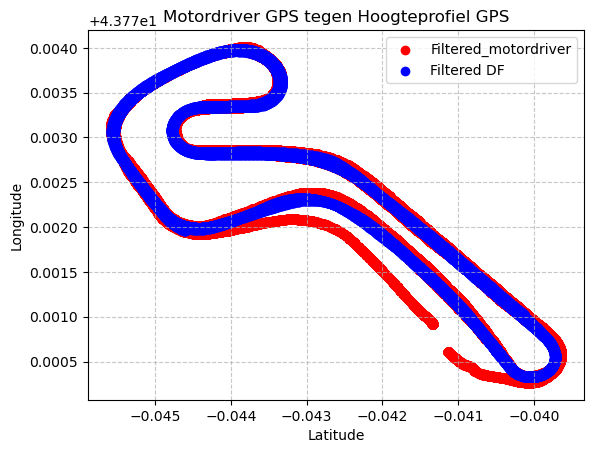

In [16]:
plt.title('Motordriver GPS tegen Hoogteprofiel GPS')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.scatter(filtered_motordriver['GPS longitude, in graden'], filtered_motordriver['GPS latitude, in graden'], color ='r', label= 'Filtered_motordriver')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], color='b', label='Filtered DF')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()

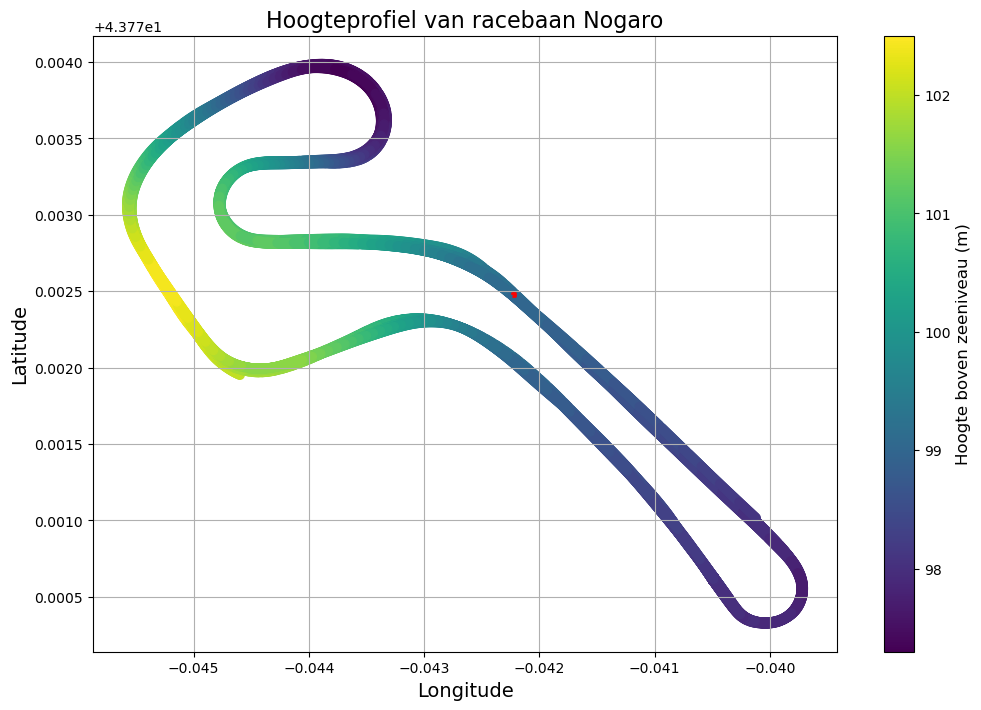

In [17]:
#Check of het is gelukt met de rondes
#Het is gelukt

def plot_hoogteprofiel_2d(latitudes, longitudes, hoogtes):
    # Increase figure size by setting the figsize
    fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height as needed
    scatter = ax.scatter(longitudes, latitudes, c=hoogtes, cmap='viridis', marker='o')
    ax.set_title('Hoogteprofiel van racebaan Nogaro', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    
    # Create the colorbar
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Hoogte boven zeeniveau (m)', fontsize=12)

    # Plot the rectangular boundaries
    plt.plot(
        [lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color='red', linestyle='--', linewidth=2, label="Boundary Square")

    for i in range(len(latitudes)):
        lat = latitudes.iloc[i]
        lon = longitudes.iloc[i]
        #plt.text(lon, lat, str(i), fontsize=8, color='black')

    # Enable grid
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Assuming `df` is your DataFrame with columns: 'latitude', 'longitude', and 'hoogte'
plot_hoogteprofiel_2d(filtered_df['latitude'], filtered_df['longitude'], filtered_df['hoogte'])


In [18]:
#Maken df's per ronde motordriver
begin_eind_paren2 = [
    (0, 26251), 
    (26251, 49486), 
    (49486, 74393), 
    (74393, 100200),
    (100200, 124732), 
    (124732, 149852), 
    (149852, 174488), 
    (174488, 200208),
    (200208, 226012), 
    (226012, 255494)
]

# Maak een lege lijst om de rondes-dataframes op te slaan
rondes = []

# Loop door elke (begin, eind) paar en maak een DataFrame subset
for i, (begin, eind) in enumerate(begin_eind_paren2):
    df_segment = filtered_motordriver.iloc[begin:eind]
    rondes.append(df_segment)

# Je kunt nu elke ronde benaderen als rondes[0], rondes[1], etc.
df_ronde1 = rondes[0]
df_ronde2 = rondes[1]
df_ronde3 = rondes[2]
df_ronde4 = rondes[3]
df_ronde5 = rondes[4]
df_ronde6 = rondes[5]
df_ronde7 = rondes[6]
df_ronde8 = rondes[7]
df_ronde9 = rondes[8]
df_ronde10 = rondes[9]

# Print het resultaat voor de eerste ronde om te controleren
df_ronde7


,Datalogger port,"Dataloggertijd, in s",Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning aan de ingang van motordriver (V),Stroom door de ingang van motordriver (A),...,"Toestand cruise control2-knop (aan=1, uit=0)",Tijdstip laatste verandering cruise control2-knop,"GPS longitude, in graden","GPS latitude, in graden",GPS direction,"GPS speed, in km/h","GPS time, in seconden sinds het begin van de huidige GPS-week",Checksum,"Wielsnelheid, in m/s","GPS speed, in m/s"
373109,5,5837.5808,03|04,2195.9629,21.155,7.969,180.1,114188,27.357,6.742,...,0,2131.384,-0.040835,43.770947,322.7,26.3,80035.0,NaN,7.287778,7.305556
373110,5,5837.5896,03|04,2195.9717,20.881,7.951,176.7,114189,27.356,6.746,...,0,2131.384,-0.040835,43.770947,322.8,26.3,80035.0,NaN,7.443889,7.305556
373111,5,5837.5984,03|04,2195.9807,20.706,7.930,175.4,114191,27.356,6.744,...,0,2131.384,-0.040835,43.770947,322.8,26.3,80035.0,NaN,7.293056,7.305556
373112,5,5837.6073,03|04,2195.9895,20.995,8.003,179.2,114193,27.355,6.746,...,0,2131.384,-0.040835,43.770947,322.8,26.3,80035.0,NaN,7.385833,7.305556
373113,5,5837.6161,03|04,2195.9983,20.981,8.040,180.1,114194,27.354,6.756,...,0,2131.384,-0.040835,43.770947,322.8,26.3,80035.0,NaN,7.293333,7.305556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397740,5,6054.6428,03|04,2412.9873,20.286,8.068,175.6,132123,27.457,6.436,...,0,2402.446,-0.040793,43.771008,324.7,24.6,80411.8,NaN,6.807778,6.833333
397741,5,6054.6516,03|04,2412.9961,20.145,7.973,172.4,132125,27.456,6.425,...,0,2402.446,-0.040793,43.771008,324.7,24.6,80411.8,NaN,6.998611,6.833333
397742,5,6054.6605,03|04,2413.0049,20.052,8.024,173.3,132126,27.455,6.431,...,0,2402.446,-0.040793,43.771008,324.7,24.6,80411.8,NaN,6.810556,6.833333
397743,5,6054.6694,03|04,2413.0139,19.878,7.993,171.0,132128,27.454,6.438,...,0,2402.446,-0.040803,43.771018,324.7,24.8,80411.8,NaN,7.021667,6.888889


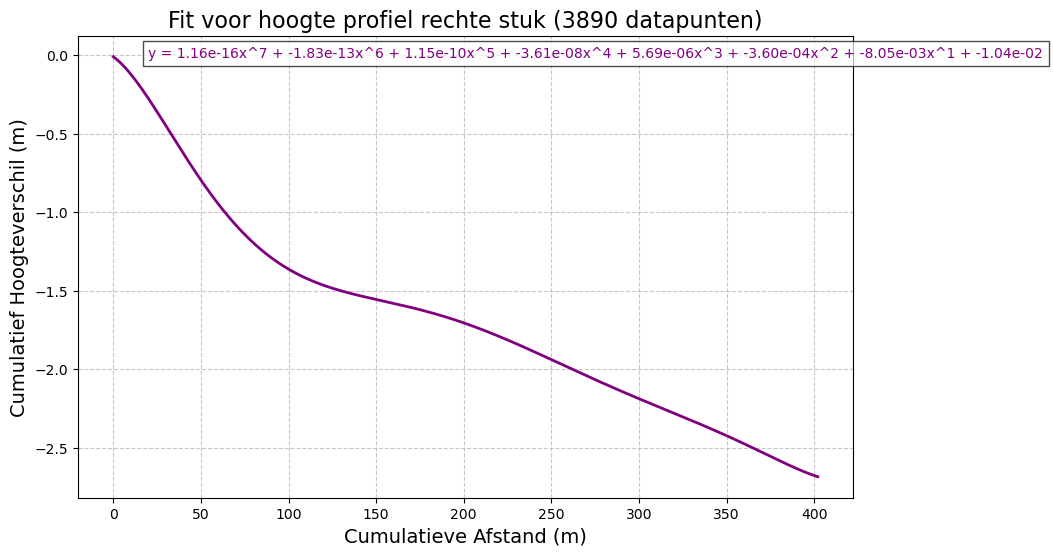

In [19]:
# Dictionary to store datasets for each segment
#formule voor h, pas x_fit aan om het aantal datapunten te veranderen
x_fit = np.linspace(0, 402, 6305)
h = polynomial_7(x_fit)

# Plot the fit equation from x = 0 to x = 275
plt.figure(figsize=(10, 6))
plt.plot(x_fit, h, color='purple', linestyle='-', linewidth=2, label=f'Polynoom fit (graad {degree})')
plt.grid(visible=True, linestyle='--', alpha=0.7)
#Add fit equation to the plot
plt.text(
    0.05 * max(x_fit),
    0.85 * max(y_fit_7),
    fit_equation_7,
    color='purple',
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.7)
)
plt.xlabel('Cumulatieve Afstand (m)', fontsize=14)
plt.ylabel('Cumulatief Hoogteverschil (m)', fontsize=14)
plt.title('Fit voor hoogte profiel rechte stuk (3890 datapunten)', fontsize=16)

plt.show() 

df_h = pd.DataFrame({'hoogteverschil (m)': h})
# Voeg een kolom toe met het verschil in hoogte (delta h)
df_h['delta h (m)'] = df_h['hoogteverschil (m)'].diff().fillna(0)


In [20]:
print(df_ronde7.loc[388561])

Datalogger port                                                          5
Dataloggertijd, in s                                             5973.7964
Format header (>03|04)                                               03|04
Tijd sinds laatste herstart motordriver (s)                      2332.1548
Spanning over de motor (V)                                           0.848
Stroom door de motor (A)                                            -0.051
Vermogen geleverd aan de motor (W)                                    -0.0
Energie geleverd aan de motor sinds reset (J)                       129044
Spanning aan de ingang van motordriver (V)                          27.362
Stroom door de ingang van motordriver (A)                            -0.01
Vermogen geleverd aan de hele motordriver (W)                         -0.3
Energie geleverd aan de hele motordriver sinds reset (J)            138398
Motordriver temperatuur (C)                                          119.9
Motordriver-bord temperat

In [21]:
print(df_ronde7.loc[394865])

Datalogger port                                                          5
Dataloggertijd, in s                                             6029.1847
Format header (>03|04)                                               03|04
Tijd sinds laatste herstart motordriver (s)                      2387.5337
Spanning over de motor (V)                                           0.018
Stroom door de motor (A)                                            -0.078
Vermogen geleverd aan de motor (W)                                    -0.0
Energie geleverd aan de motor sinds reset (J)                       129044
Spanning aan de ingang van motordriver (V)                          30.269
Stroom door de ingang van motordriver (A)                           -0.039
Vermogen geleverd aan de hele motordriver (W)                         -1.2
Energie geleverd aan de hele motordriver sinds reset (J)            138351
Motordriver temperatuur (C)                                         119.35
Motordriver-bord temperat

In [22]:
df_h*-1

,hoogteverschil (m),delta h (m)
0,0.010444,-0.000000
1,0.010959,0.000515
2,0.011477,0.000518
3,0.011998,0.000521
4,0.012521,0.000524
...,...,...
6300,2.684239,0.000227
6301,2.684466,0.000227
6302,2.684692,0.000226
6303,2.684918,0.000225


In [23]:
import pandas as pd

# Berekenen zwaartekracht
massa = 90  # Mass in kg
g = 9.81  # Gravitational acceleration in m/s²

# Initial speed in m/s
begin_snelheid = df_ronde7.loc[388561, "Wielsnelheid, in m/s"]
begin_snelheid_GPS = df_ronde7.loc[394865, "GPS speed, in m/s"]
print(f"Initial speed: {begin_snelheid} m/s")
print(f"Initial speed: {begin_snelheid_GPS} m/s")
# Bereken de initiële kinetische energie
initiele_kinetische_energie = 0.5 * massa * begin_snelheid**2
print(f"Initiële kinetische energie: {initiele_kinetische_energie} J")

initiele_kinetische_energie_GPS = 0.5 * massa * begin_snelheid_GPS**2
print(f"Initiële kinetische energie: {initiele_kinetische_energie_GPS} J")
# 
# Maak een nieuwe lege DataFrame df_e met dezelfde index als df_h
df_e = pd.DataFrame(index=df_h.index)

# Bereken potentiële energie per punt op basis van de hoogteverschillen (neem absolute waarde van delta h)
initiele_potentiële_energie = massa * g * (df_h['hoogteverschil (m)'].iloc[0] - df_h['hoogteverschil (m)'].iloc[6304])
print(f"Initiële potentiële energie: {initiele_potentiële_energie} J")

df_e['Absolute Potentiële Energie verlies(J)'] = massa * g * df_h['delta h (m)'].abs()

# Bereken de omzetting van potentiële energie naar kinetische energie
df_e['Omzetting naar Kinetische Energie (J)'] = df_e['Absolute Potentiële Energie verlies(J)']
df_e['Omzetting naar Potentiële Energie (J)'] = df_e['Absolute Potentiële Energie verlies(J)']

# Bereken de cumulatieve som van de omzetting naar kinetische energie
df_e['Kinetische Energie Totaal (J)'] = df_e['Omzetting naar Kinetische Energie (J)'].cumsum()
df_e['Kinetische Energie Totaal met GPS snelheid (J)'] = df_e['Omzetting naar Kinetische Energie (J)'].cumsum()
# Voeg de initiële kinetische energie toe aan de hele kolom
df_e['Kinetische Energie Totaal (J)'] += initiele_kinetische_energie
df_e['Kinetische Energie Totaal met GPS snelheid (J)'] += initiele_kinetische_energie_GPS

# Bereken de totale potentiële energie en voeg de initiële potentiële energie toe
df_e['Potentiële Energie Totaal (J)'] = df_e['Omzetting naar Potentiële Energie (J)'][::-1].cumsum()[::-1]
df_e['Potentiële Energie Totaal (J)'] += initiele_potentiële_energie

# Bereken de totale energie
df_e['Totale Energie (J)'] = df_e['Potentiële Energie Totaal (J)'] + df_e['Kinetische Energie Totaal (J)']
df_e['Totale Energie met GPS snelheid (J)'] = df_e['Potentiële Energie Totaal (J)'] + df_e['Kinetische Energie Totaal met GPS snelheid (J)']

totale_energie_GPS = df_e['Totale Energie met GPS snelheid (J)'].values
totale_energie = df_e['Totale Energie (J)'].values

array_potentieel = df_e['Potentiële Energie Totaal (J)'].values
# Sla de potentiële energie op in een variabele voor gebruik in de tweede cel
potentiele_energie_uit_df_e = array_potentieel
print(potentiele_energie_uit_df_e)
# Print het resultaat voor controle
df_e


Initial speed: 6.819722222222222 m/s
Initial speed: 6.833333333333334 m/s
Initiële kinetische energie: 2092.887503472222 J
Initiële kinetische energie: 2101.2500000000005 J
Initiële potentiële energie: 2361.4912600035286 J
[4722.98252001 4722.98252001 4722.5278224  ... 2362.08841876 2361.88878187
 2361.68972821]


,Absolute Potentiële Energie verlies(J),Omzetting naar Kinetische Energie (J),Omzetting naar Potentiële Energie (J),Kinetische Energie Totaal (J),Kinetische Energie Totaal met GPS snelheid (J),Potentiële Energie Totaal (J),Totale Energie (J),Totale Energie met GPS snelheid (J)
0,0.000000,0.000000,0.000000,2092.887503,2101.250000,4722.982520,6815.870023,6824.232520
1,0.454698,0.454698,0.454698,2093.342201,2101.704698,4722.982520,6816.324721,6824.687218
2,0.457277,0.457277,0.457277,2093.799478,2102.161975,4722.527822,6816.327301,6824.689797
3,0.459849,0.459849,0.459849,2094.259327,2102.621824,4722.070545,6816.329872,6824.692369
4,0.462413,0.462413,0.462413,2094.721740,2103.084237,4721.610696,6816.332436,6824.694933
...,...,...,...,...,...,...,...,...
6300,0.200797,0.200797,0.200797,4453.581387,4461.943883,2362.489433,6816.070820,6824.433317
6301,0.200218,0.200218,0.200218,4453.781605,4462.144101,2362.288637,6816.070241,6824.432738
6302,0.199637,0.199637,0.199637,4453.981242,4462.343738,2362.088419,6816.069660,6824.432157
6303,0.199054,0.199054,0.199054,4454.180295,4462.542792,2361.888782,6816.069077,6824.431574


In [24]:
start_index = 388561
end_index = start_index + 6304

# Bereken de kinetische energie met de gemeten snelheden van df_ronde6
gemeten_snelheden = df_ronde7.loc[start_index:end_index, "Wielsnelheid, in m/s"]
df_e_kin = pd.DataFrame(index=gemeten_snelheden.index)  # Nieuwe DataFrame voor de gemeten kinetische energie
df_e_kin["Afgelegde afstand (m)"] = df_ronde7.loc[start_index:end_index, "Afgelegde afstand sinds laatste herstart motordriver (m)"]
df_e_kin['Gemeten_snelheden_GPS (m/s)'] = df_ronde7.loc[start_index:end_index, "GPS speed, in m/s"]
df_e_kin['Gemeten Snelheid (m/s)'] = gemeten_snelheden
df_e_kin['Kinetische Energie (J)'] = 0.5 * massa * df_e_kin['Gemeten Snelheid (m/s)']**2
df_e_kin['Kinetische Energie met GPS snelheid (J)'] = 0.5 * massa * df_e_kin['Gemeten_snelheden_GPS (m/s)']**2
# Zorg dat de potentiële energie wordt gesynchroniseerd met df_e


# Vul eventuele NaN-waarden op

# Voeg de potentiële energie toe aan df_e_kin
df_e_kin['Potentiële Energie Totaal (J)'] = potentiele_energie_uit_df_e

# Bereken de totale energie
df_e_kin['Totale Energie (J)'] = df_e_kin['Potentiële Energie Totaal (J)'] + df_e_kin['Kinetische Energie (J)']

df_e_kin['Totale Energie met GPS snelheid (J)'] = df_e_kin['Potentiële Energie Totaal (J)'] + df_e_kin['Kinetische Energie met GPS snelheid (J)']
# Controleer de DataFrame op NaN-waarden
if df_e_kin.isna().any().any():
    print("Waarschuwing: Er zijn nog NaN-waarden in df_e_kin!")
    
df_e_kin["Totale theoretische Energie met GPS snelheid (J)"] = totale_energie_GPS
df_e_kin["Energie vershil met GPS snelheid (J)"] = df_e_kin["Totale theoretische Energie met GPS snelheid (J)"] - df_e_kin["Totale Energie met GPS snelheid (J)"]

df_e_kin["Totale theoretische energie (J)"] = totale_energie
df_e_kin["Energie vershil (J)"] = df_e_kin["Totale theoretische energie (J)"] - df_e_kin["Totale Energie (J)"]

df_e_kin["delta energie met GPS snelheid (J)"] = df_e_kin["Energie vershil met GPS snelheid (J)"].diff()
df_e_kin["delta afstand"] = df_e_kin["Afgelegde afstand (m)"].diff()
df_e_kin["delta energie (J)"] = df_e_kin["Energie vershil (J)"].diff()

df_e_kin['Weerstand met GPS Snelheid (N)'] = df_e_kin["delta energie met GPS snelheid (J)"] / df_e_kin["delta afstand"]
df_e_kin['Weerstand (N)'] = df_e_kin["delta energie met GPS snelheid (J)"] / df_e_kin["delta afstand"]
# Print het resultaat voor controle
df_e_kin


,Afgelegde afstand (m),Gemeten_snelheden_GPS (m/s),Gemeten Snelheid (m/s),Kinetische Energie (J),Kinetische Energie met GPS snelheid (J),Potentiële Energie Totaal (J),Totale Energie (J),Totale Energie met GPS snelheid (J),Totale theoretische Energie met GPS snelheid (J),Energie vershil met GPS snelheid (J),Totale theoretische energie (J),Energie vershil (J),delta energie met GPS snelheid (J),delta afstand,delta energie (J),Weerstand met GPS Snelheid (N),Weerstand (N)
388561,10512.16,6.750000,6.819722,2092.887503,2050.312500,4722.982520,6815.870023,6773.295020,6824.232520,50.937500,6815.870023,0.000000,NaN,NaN,NaN,NaN,NaN
388562,10512.22,6.750000,6.845278,2108.602253,2050.312500,4722.982520,6831.584773,6773.295020,6824.687218,51.392198,6816.324721,-15.260052,0.454698,0.06,-15.260052,7.578293,7.578293
388563,10512.29,6.777778,6.840833,2105.865031,2067.222222,4722.527822,6828.392854,6789.750045,6824.689797,34.939753,6816.327301,-12.065553,-16.452445,0.07,3.194499,-235.034929,-235.034929
388564,10512.35,6.777778,6.848056,2110.313920,2067.222222,4722.070545,6832.384465,6789.292767,6824.692369,35.399602,6816.329872,-16.054593,0.459849,0.06,-3.989040,7.664150,7.664150
388565,10512.41,6.777778,6.861944,2118.882670,2067.222222,4721.610696,6840.493366,6788.832918,6824.694933,35.862015,6816.332436,-24.160930,0.462413,0.06,-8.106337,7.706883,7.706883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394861,10914.48,6.833333,6.776944,2066.713920,2101.250000,2362.489433,4429.203353,4463.739433,6824.433317,2360.693883,6816.070820,2386.867467,0.200797,0.12,114.577047,1.673306,1.673306
394862,10914.48,6.833333,6.955000,2176.741125,2101.250000,2362.288637,4539.029762,4463.538637,6824.432738,2360.894101,6816.070241,2277.040480,0.200218,0.00,-109.826987,inf,inf
394863,10914.60,6.833333,6.768889,2061.803556,2101.250000,2362.088419,4423.891974,4463.338419,6824.432157,2361.093738,6816.069660,2392.177686,0.199637,0.12,115.137206,1.663641,1.663641
394864,10914.60,6.833333,6.943611,2169.618087,2101.250000,2361.888782,4531.506869,4463.138782,6824.431574,2361.292792,6816.069077,2284.562208,0.199054,0.00,-107.615478,inf,inf


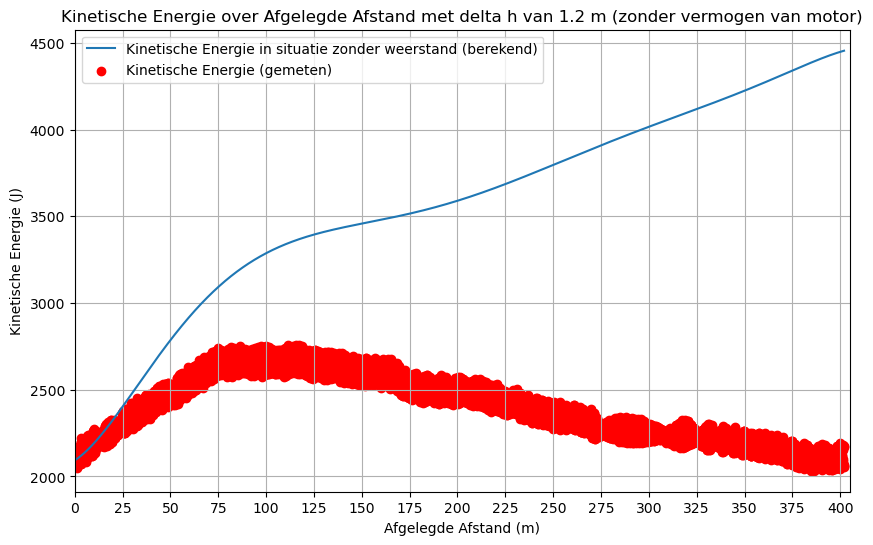

In [25]:
# Plot de kinetische energie tegen de afgelegde afstand
x= np.linspace(0,402,6305)
plt.figure(figsize=(10, 6))
plt.plot(x, df_e['Kinetische Energie Totaal (J)'], label='Kinetische Energie in situatie zonder weerstand (berekend)')
plt.scatter(x, df_e_kin['Kinetische Energie (J)'], label='Kinetische Energie (gemeten)', color = 'r')


# Labels en titel toevoegen
plt.xlim(0,405)
plt.xticks(np.arange(0, 405, 25))  # Stel de x-as in stappen van 25
plt.xlabel('Afgelegde Afstand (m)')
plt.ylabel('Kinetische Energie (J)')
plt.title('Kinetische Energie over Afgelegde Afstand met delta h van 1.2 m (zonder vermogen van motor)')
plt.legend()
plt.grid(True)

# Toon de grafiek
plt.show()

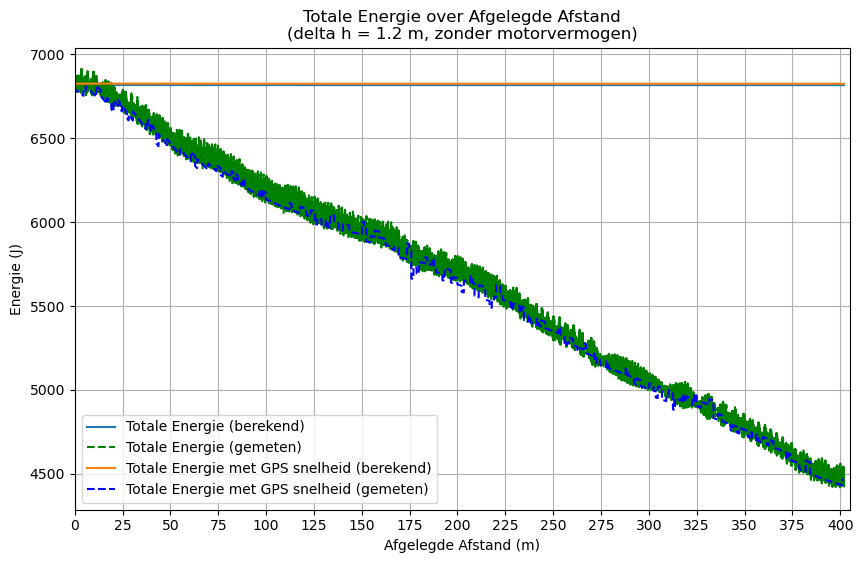

In [26]:
# Genereer de x-as op basis van de afgelegde afstand
x = np.linspace(0, 402, 6305)

# Maak de plot
plt.figure(figsize=(10, 6))

# Plot de kinetische energie (berekend en gemeten)
plt.plot(x, df_e['Totale Energie (J)'], label='Totale Energie (berekend)')
#plt.scatter(x, df_e_kin['Kinetische Energie (J)'], label='Kinetische Energie (gemeten)', color='r')

# Plot de totale energie
plt.plot(x, df_e_kin['Totale Energie (J)'], label='Totale Energie (gemeten)', color='g', linestyle='--')

plt.plot(x, df_e['Totale Energie met GPS snelheid (J)'], label='Totale Energie met GPS snelheid (berekend)')
#plt.scatter(x, df_e_kin['Kinetische Energie (J)'], label='Kinetische Energie (gemeten)', color='r')

# Plot de totale energie
plt.plot(x, df_e_kin['Totale Energie met GPS snelheid (J)'], label='Totale Energie met GPS snelheid (gemeten)', color='b', linestyle='--')
# Labels en titel toevoegen
plt.xlim(0, 405)
plt.xticks(np.arange(0, 405, 25))  # Stel de x-as in stappen van 25
plt.xlabel('Afgelegde Afstand (m)')
plt.ylabel('Energie (J)')
plt.title('Totale Energie over Afgelegde Afstand\n(delta h = 1.2 m, zonder motorvermogen)')
plt.legend()
plt.grid(True)

# Toon de grafiek
plt.show()


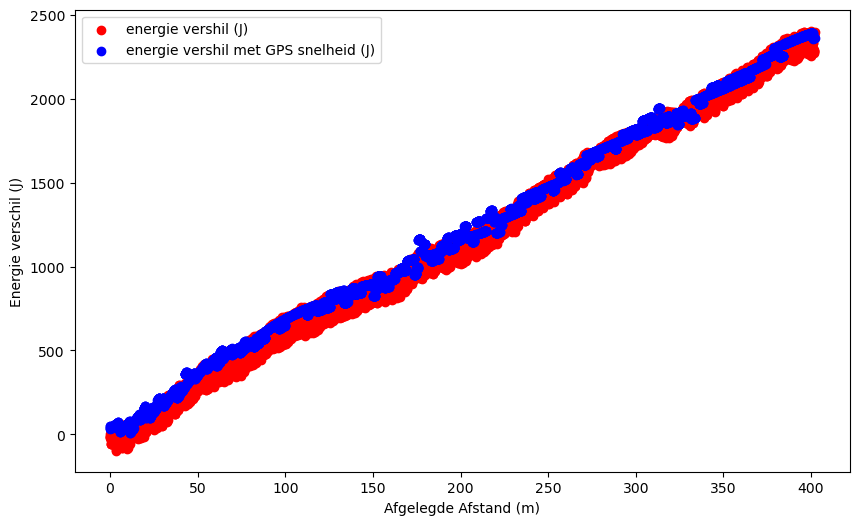

In [27]:
plt.figure(figsize=(10, 6))

plt.scatter(x,df_e_kin["Energie vershil (J)"], label='energie vershil (J)', color = 'r')
plt.scatter(x,df_e_kin["Energie vershil met GPS snelheid (J)"], label='energie vershil met GPS snelheid (J)', color = 'b')
plt.xlabel('Afgelegde Afstand (m)')
plt.ylabel('Energie verschil (J)')
plt.legend()
plt.show()


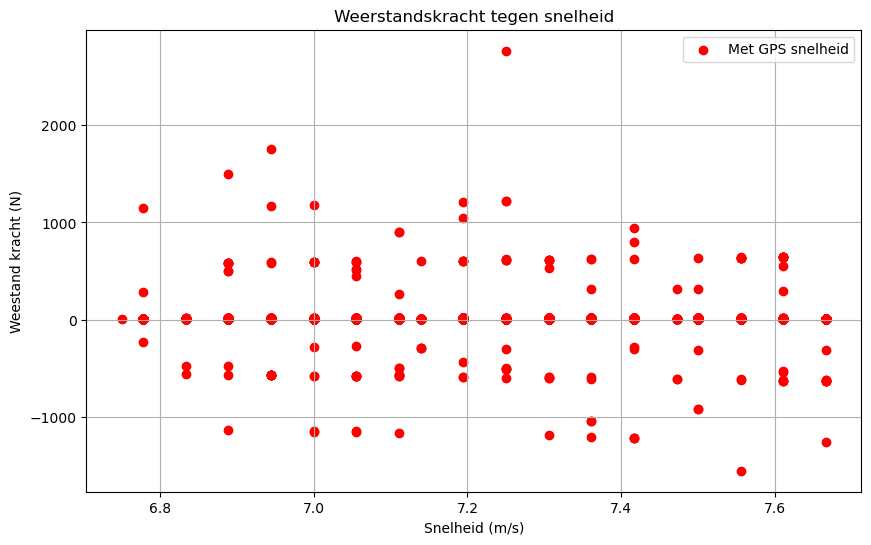

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(df_e_kin["Gemeten_snelheden_GPS (m/s)"],df_e_kin['Weerstand met GPS Snelheid (N)'], label='Met GPS snelheid', color = 'r')
#plt.scatter(df_e_kin["Gemeten Snelheid (m/s)"],df_e_kin['Weerstand (N)'], label='Met wielsnelheid', color = 'b')

plt.title('Weerstandskracht tegen snelheid')
plt.xlabel('Snelheid (m/s)')
plt.ylabel('Weestand kracht (N)')
plt.legend()
plt.grid()
plt.show()

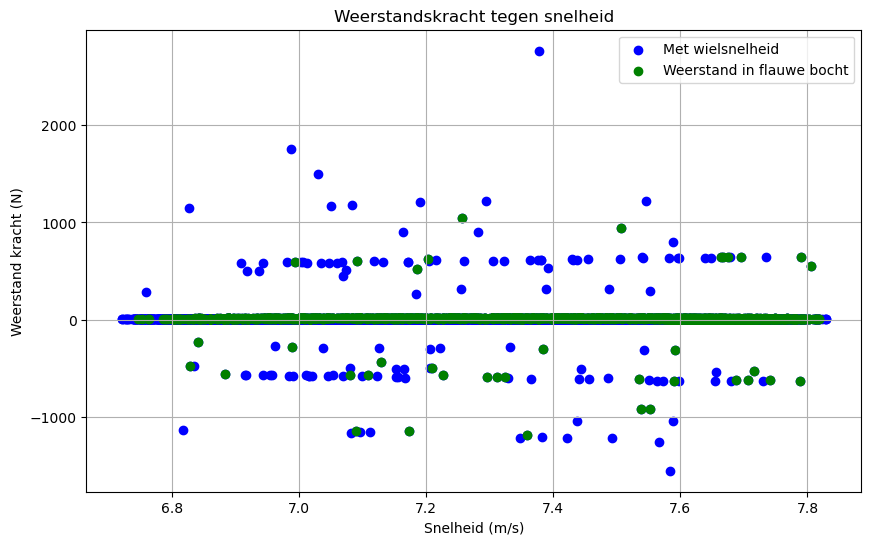

In [29]:
import matplotlib.pyplot as plt

# Eerst, laten we de data voor de specifieke index range voorbereiden
specifieke_indices = df_e_kin.loc[388561:390300]

plt.figure(figsize=(10, 6))

# Teken alle punten
plt.scatter(df_e_kin["Gemeten Snelheid (m/s)"], df_e_kin['Weerstand (N)'],
            label='Met wielsnelheid', color='b')

# Teken nu de specifieke punten in het groen
plt.scatter(specifieke_indices["Gemeten Snelheid (m/s)"], specifieke_indices['Weerstand (N)'],
            color='green', label='Weerstand in flauwe bocht')

plt.title('Weerstandskracht tegen snelheid')
plt.xlabel('Snelheid (m/s)')
plt.ylabel('Weerstand kracht (N)')
plt.legend()
plt.grid()
plt.show()


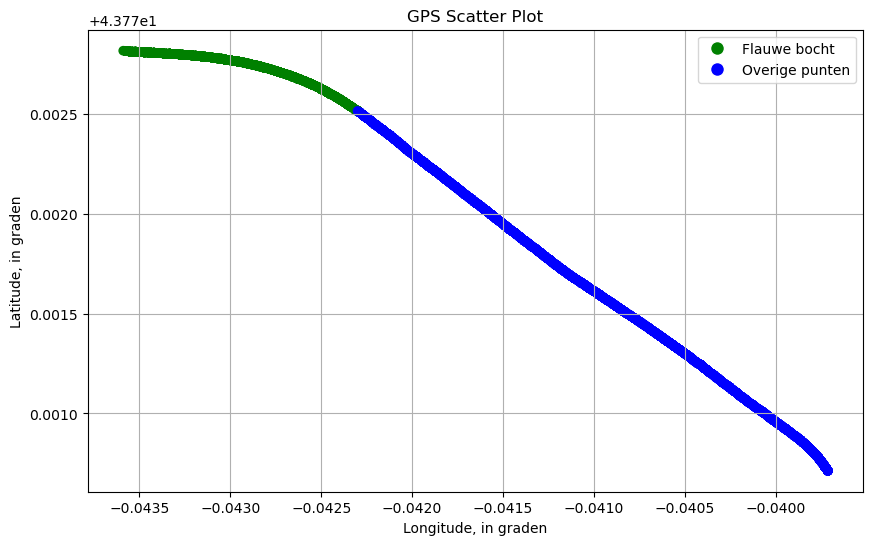

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Stel de DataFrame opnieuw samen voor het rechte stuk
rechte_stuk_ronde7 = filtered_motordriver.loc[388561:394865]

# Bereid een kleurenarray voor alle punten, standaard ingesteld op blauw
colors = ['blue'] * len(rechte_stuk_ronde7)

# Vind de indices van de specifieke punten en zet de kleur naar groen
special_indices = [388561, 390300]
index_positions = [rechte_stuk_ronde7.index.get_loc(idx) for idx in special_indices if idx in rechte_stuk_ronde7.index]

# Als beide indices gevonden zijn, kleur alle punten tussen deze indices groen
if len(index_positions) == 2:
    start_pos, end_pos = sorted(index_positions)  # Zorg ervoor dat start_pos < end_pos
    for i in range(start_pos, end_pos + 1):
        colors[i] = 'green'

# Maak de scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    rechte_stuk_ronde7['GPS longitude, in graden'],
    rechte_stuk_ronde7['GPS latitude, in graden'],
    color=colors,
    label='GPS Data Points'
)

# Extra's toevoegen
plt.title('GPS Scatter Plot')
plt.xlabel('Longitude, in graden')
plt.ylabel('Latitude, in graden')
plt.grid(True)

# Legenda toevoegen
green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Flauwe bocht')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Overige punten')
plt.legend(handles=[green_patch, blue_patch])

# Toon de plot
plt.show()


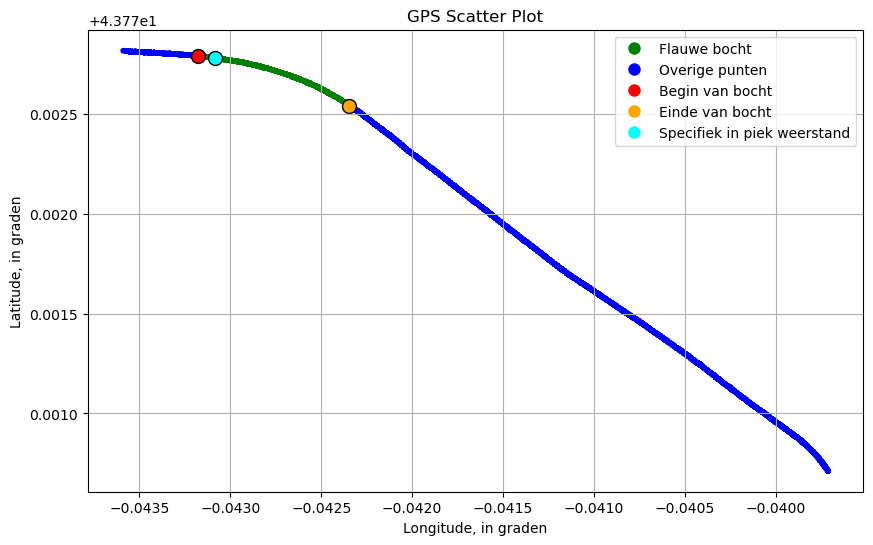

In [31]:
import matplotlib.pyplot as plt

# Stel de DataFrame opnieuw samen voor het rechte stuk
rechte_stuk_ronde7 = filtered_motordriver.loc[388561:394865]

# Bereid een kleurenarray voor alle punten, standaard ingesteld op blauw
colors = ['blue'] * len(rechte_stuk_ronde7)

# Vind de indices van de specifieke punten en zet de kleur naar groen
special_indices = [389106, 390200]
index_positions = [rechte_stuk_ronde7.index.get_loc(idx) for idx in special_indices if idx in rechte_stuk_ronde7.index]

# Als beide indices gevonden zijn, kleur alle punten tussen deze indices groen
if len(index_positions) == 2:
    start_pos, end_pos = sorted(index_positions)  # Zorg ervoor dat start_pos < end_pos
    for i in range(start_pos, end_pos + 1):
        colors[i] = 'green'
    # Zet de eerste waarde op rood en de laatste op oranje
    colors[start_pos] = 'red'
    colors[end_pos] = 'orange'

# Specifiek punt op rij 389221 instellen op cyan
if 389221 in rechte_stuk_ronde7.index:
    cyan_pos = rechte_stuk_ronde7.index.get_loc(389221)
    colors[cyan_pos] = 'cyan'

# Maak de scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    rechte_stuk_ronde7['GPS longitude, in graden'],
    rechte_stuk_ronde7['GPS latitude, in graden'],
    color=colors,
    s=10  # Standaard grootte van de punten
)

# Extra's toevoegen
plt.title('GPS Scatter Plot')
plt.xlabel('Longitude, in graden')
plt.ylabel('Latitude, in graden')
plt.grid(True)

# Vergroot de grootte van de speciale punten (rood, oranje en cyan) voor betere zichtbaarheid
for i in [start_pos, end_pos, cyan_pos]:
    plt.scatter(
        rechte_stuk_ronde7.iloc[i]['GPS longitude, in graden'],
        rechte_stuk_ronde7.iloc[i]['GPS latitude, in graden'],
        color=colors[i],
        s=100,  # Grotere grootte voor de speciale punten
        edgecolor='black'  # Voeg een rand toe voor betere zichtbaarheid
    )

# Legenda toevoegen
green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Flauwe bocht')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Overige punten')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Begin van bocht')
orange_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Einde van bocht')
cyan_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=10, label='Specifiek in piek weerstand')
plt.legend(handles=[green_patch, blue_patch, red_patch, orange_patch, cyan_patch])

# Toon de plot
plt.show()


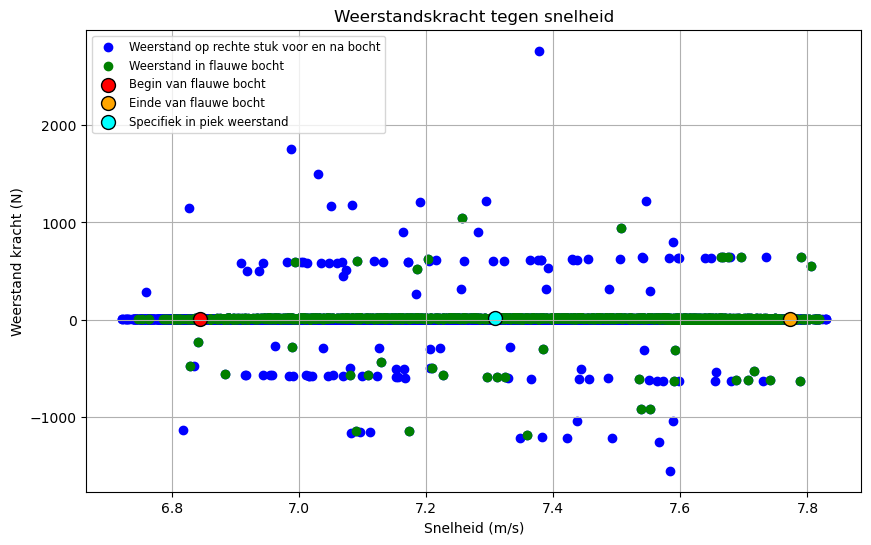

In [32]:
import matplotlib.pyplot as plt
#Met wielsnelheid

# Eerst, laten we de data voor de specifieke index range voorbereiden
specifieke_indices = df_e_kin.loc[388561:390200]

plt.figure(figsize=(10, 6))

# Teken alle punten in blauw
plt.scatter(df_e_kin["Gemeten Snelheid (m/s)"], df_e_kin['Weerstand (N)'],
            label='Weerstand op rechte stuk voor en na bocht', color='b')

# Teken nu de specifieke punten in het groen
plt.scatter(specifieke_indices["Gemeten Snelheid (m/s)"], specifieke_indices['Weerstand (N)'],
            color='green', label='Weerstand in flauwe bocht')

# Markeer het beginpunt met rood
plt.scatter(df_e_kin.loc[388562, "Gemeten Snelheid (m/s)"], df_e_kin.loc[388562, 'Weerstand (N)'],
            color='red', label='Begin van flauwe bocht', s=100, edgecolor='black')

# Markeer het eindpunt met oranje
plt.scatter(df_e_kin.loc[390200, "Gemeten Snelheid (m/s)"], df_e_kin.loc[390200, 'Weerstand (N)'],
            color='orange', label='Einde van flauwe bocht', s=100, edgecolor='black')

# Markeer een ander specifiek punt met cyan
plt.scatter(df_e_kin.loc[389221, "Gemeten Snelheid (m/s)"], df_e_kin.loc[389221, 'Weerstand (N)'],
            color='cyan', label='Specifiek in piek weerstand', s=100, edgecolor='black')

plt.title('Weerstandskracht tegen snelheid')
plt.xlabel('Snelheid (m/s)')
plt.ylabel('Weerstand kracht (N)')
plt.grid(True)

# We passen de legenda aan zodat elk label maar één keer verschijnt
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Verwijder duplicaten

# Pas de legenda aan: kleinere lettergrootte en plaatsing linksboven
plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize='small')

plt.show()


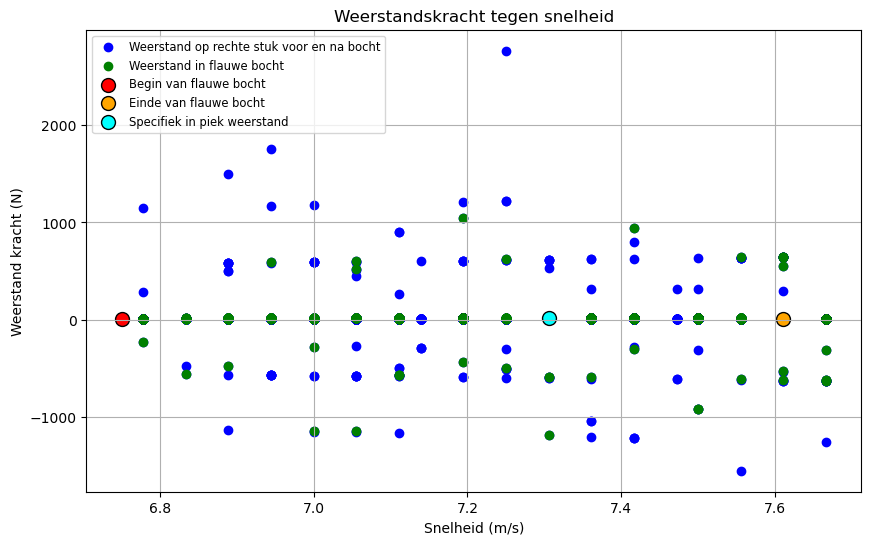

In [33]:
import matplotlib.pyplot as plt
#Met GPS snelheid

# Eerst, laten we de data voor de specifieke index range voorbereiden
specifieke_indices = df_e_kin.loc[388561:390200]

plt.figure(figsize=(10, 6))

# Teken alle punten in blauw
plt.scatter(df_e_kin["Gemeten_snelheden_GPS (m/s)"], df_e_kin['Weerstand (N)'],
            label='Weerstand op rechte stuk voor en na bocht', color='b')

# Teken nu de specifieke punten in het groen
plt.scatter(specifieke_indices["Gemeten_snelheden_GPS (m/s)"], specifieke_indices['Weerstand (N)'],
            color='green', label='Weerstand in flauwe bocht')

# Markeer het beginpunt met rood
plt.scatter(df_e_kin.loc[388562, "Gemeten_snelheden_GPS (m/s)"], df_e_kin.loc[388562, 'Weerstand (N)'],
            color='red', label='Begin van flauwe bocht', s=100, edgecolor='black')

# Markeer het eindpunt met oranje
plt.scatter(df_e_kin.loc[390200, "Gemeten_snelheden_GPS (m/s)"], df_e_kin.loc[390200, 'Weerstand (N)'],
            color='orange', label='Einde van flauwe bocht', s=100, edgecolor='black')

# Markeer een ander specifiek punt met cyan
plt.scatter(df_e_kin.loc[389221, "Gemeten_snelheden_GPS (m/s)"], df_e_kin.loc[389221, 'Weerstand (N)'],
            color='cyan', label='Specifiek in piek weerstand', s=100, edgecolor='black')

plt.title('Weerstandskracht tegen snelheid')
plt.xlabel('Snelheid (m/s)')
plt.ylabel('Weerstand kracht (N)')
plt.grid(True)

# We passen de legenda aan zodat elk label maar één keer verschijnt
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Verwijder duplicaten

# Pas de legenda aan: kleinere lettergrootte en plaatsing linksboven
plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize='small')

plt.show()


In [34]:
print(df_e_kin.loc[389220:389234])
#rij 389230 is anomalie

        Afgelegde afstand (m)  Gemeten_snelheden_GPS (m/s)  \
389220               10553.21                     7.305556   
389221               10553.27                     7.305556   
389222               10553.33                     7.305556   
389223               10553.39                     7.305556   
389224               10553.45                     7.305556   
389225               10553.52                     7.305556   
389226               10553.58                     7.305556   
389227               10553.64                     7.305556   
389228               10553.70                     7.305556   
389229               10553.76                     7.305556   
389230               10553.83                     7.194444   
389231               10553.89                     7.194444   
389232               10554.01                     7.194444   
389233               10554.01                     7.194444   
389234               10554.14                     7.194444   

       

In [35]:
# Aangenomen dat df_e_kin correct is gedefinieerd en start_index is ingesteld op het punt dat je als rood hebt gemarkeerd

# Verkrijg de weerstandswaarde op het rode punt
weerstand_rood_punt = df_e_kin.loc[start_index, 'Weerstand (N)']

# Controleer of er weerstand is (weerstand is groter dan 0)
if weerstand_rood_punt > 0:
    print(f"Er is weerstand op het rode punt: {weerstand_rood_punt} N")
else:
    print("Er is geen weerstand op het rode punt, of de weerstand is 0 N.")


Er is geen weerstand op het rode punt, of de weerstand is 0 N.


Animation saved as dynamic_tracking_single_color.html.


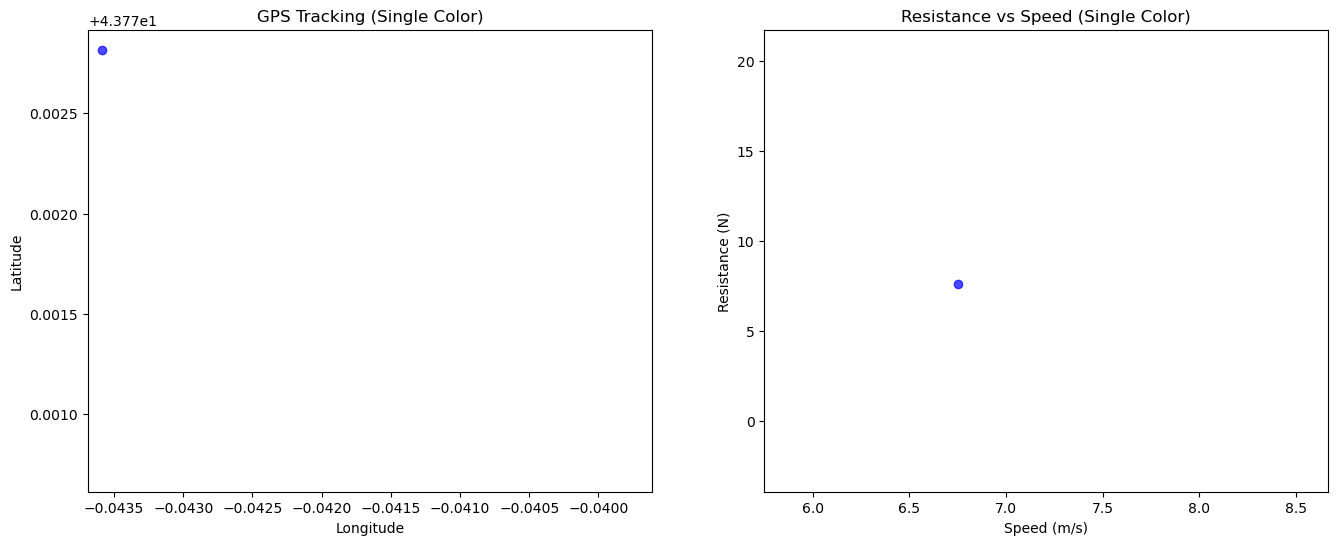

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, HTMLWriter
import pandas as pd

# Assuming 'df_e_kin' and 'filtered_motordriver' are your dataframes and correctly loaded with data

# Convert speeds to m/s
df_e_kin['Speed_m/s'] = df_e_kin['Gemeten_snelheden_GPS (m/s)']

# Remove rows where acceleration, speed, or resistance is NaN or infinite
df_e_kin = df_e_kin.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
df_e_kin = df_e_kin.dropna(subset=['Speed_m/s', 'Weerstand (N)'])  # Drop rows with NaN in these columns

# Filter data for resistance between 0 and 20 N
df_e_kin = df_e_kin[(df_e_kin['Weerstand (N)'] >= 0) & (df_e_kin['Weerstand (N)'] <= 20)]

# Prepare the figure for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Setup for GPS data plot
ax1.set_xlim(rechte_stuk_ronde7['GPS longitude, in graden'].min() - 0.0001, rechte_stuk_ronde7['GPS longitude, in graden'].max() + 0.0001)
ax1.set_ylim(rechte_stuk_ronde7['GPS latitude, in graden'].min() - 0.0001, rechte_stuk_ronde7['GPS latitude, in graden'].max() + 0.0001)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("GPS Tracking (Single Color)")

# Setup for resistance vs speed plot
ax2.set_xlim(df_e_kin['Speed_m/s'].min() - 1, df_e_kin['Speed_m/s'].max() + 1)
ax2.set_ylim(df_e_kin['Weerstand (N)'].min() - 5, df_e_kin['Weerstand (N)'].max() + 5)
ax2.set_xlabel("Speed (m/s)")
ax2.set_ylabel("Resistance (N)")
ax2.set_title("Resistance vs Speed (Single Color)")

# Initialize scatter plots
scat1 = ax1.scatter([], [], color='blue', alpha=0.7)
scat2 = ax2.scatter([], [], color='blue', alpha=0.7)

# Add a legend for acceleration categories
legend_labels = [
    ('red', 'Voor bocht'),
    ('blue', 'In bocht'),
    ('yellow', 'Na bocht')
]
for color, label in legend_labels:
    ax2.scatter([], [], color=color, label=label)  # Dummy points for legend
ax2.legend(title="Kleurenlegenda", loc='upper left')

# Define the update function for the animation
def update(frame):
    end = frame + 1  # Display one additional row per frame
    if end > len(df_e_kin):  # Stop when all data is shown
        return

    # Extract data chunk
    chunk = df_e_kin.iloc[:end]  # Include all data up to the current frame

    colors = chunk.index.map(
    lambda i: 'red' if i < 389106 else ('blue' if i <= 390200 else 'yellow'))
    
    # Update the GPS plot
    chunk_lat = rechte_stuk_ronde7.iloc[:end]['GPS latitude, in graden']
    chunk_lon = rechte_stuk_ronde7.iloc[:end]['GPS longitude, in graden']
    scat1.set_offsets(np.column_stack((chunk_lon, chunk_lat)))
    
    # Update the resistance vs speed plot
    scat2.set_offsets(np.column_stack((chunk['Speed_m/s'], chunk['Weerstand (N)'])))

# Animation settings
frames_count = max(len(rechte_stuk_ronde7), len(df_e_kin))
anim = FuncAnimation(fig, update, frames=frames_count, repeat=False, interval=100)  # Adjust the interval as needed

# Save as HTML file
output_path = "dynamic_tracking_single_color.html"
html_writer = HTMLWriter()
anim.save(output_path, writer=html_writer)

print(f"Animation saved as {output_path}.")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, HTMLWriter
import pandas as pd

# Veronderstel dat 'df_e_kin' en 'rechte_stuk_ronde7' correct zijn geladen met de benodigde data

# Converteer snelheden naar m/s
df_e_kin['Speed_m/s'] = df_e_kin['Gemeten_snelheden_GPS (m/s)']

# Verwijder rijen waar snelheid of weerstand NaN of oneindig is
df_e_kin = df_e_kin.replace([np.inf, -np.inf], np.nan)  # Vervang inf/-inf door NaN
df_e_kin = df_e_kin.dropna(subset=['Speed_m/s', 'Weerstand (N)'])  # Verwijder rijen met NaN in deze kolommen

# Filter data voor weerstand tussen 0 en 20 N
df_e_kin = df_e_kin[(df_e_kin['Weerstand (N)'] >= 0) & (df_e_kin['Weerstand (N)'] <= 20)]

# Bereid de figuur voor om te plotten
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Instellingen voor GPS-gegevensplot
ax1.set_xlim(rechte_stuk_ronde7['GPS longitude, in graden'].min() - 0.0001, rechte_stuk_ronde7['GPS longitude, in graden'].max() + 0.0001)
ax1.set_ylim(rechte_stuk_ronde7['GPS latitude, in graden'].min() - 0.0001, rechte_stuk_ronde7['GPS latitude, in graden'].max() + 0.0001)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("GPS Tracking (Single Color)")

# Instellingen voor weerstand versus snelheid plot
ax2.set_xlim(df_e_kin['Speed_m/s'].min() - 1, df_e_kin['Speed_m/s'].max() + 1)
ax2.set_ylim(df_e_kin['Weerstand (N)'].min() - 5, df_e_kin['Weerstand (N)'].max() + 5)
ax2.set_xlabel("Speed (m/s)")
ax2.set_ylabel("Resistance (N)")
ax2.set_title("Resistance vs Speed (Single Color)")

# Initialiseer scatter plots met lege numpy-arrays
scat1 = ax1.scatter([], [], color='blue', alpha=0.7, animated=True)
scat2 = ax2.scatter([], [], color='blue', alpha=0.7, animated=True)

# Voeg een legenda toe voor acceleratiecategorieën
legend_labels = [
    ('red', 'Voor bocht'),
    ('blue', 'In bocht'),
    ('yellow', 'Na bocht')
]
for color, label in legend_labels:
    ax2.scatter([], [], color=color, label=label)  # Dummy punten voor legenda
ax2.legend(title="Kleurenlegenda", loc='upper left')

# Definieer de initialisatiefunctie voor de animatie
def init():
    scat1.set_offsets(np.empty((0, 2)))
    scat2.set_offsets(np.empty((0, 2)))
    return scat1, scat2

# Definieer de updatefunctie voor de animatie
def update(frame):
    end = frame + 1  # Toon één extra rij per frame
    if end > len(df_e_kin):  # Stop wanneer alle data is weergegeven
        return scat1, scat2

    # Haal data op tot het huidige frame
    chunk = df_e_kin.iloc[:end]

    # Update de GPS-plot
    chunk_lat = rechte_stuk_ronde7.iloc[:end]['GPS latitude, in graden']
    chunk_lon = rechte_stuk_ronde7.iloc[:end]['GPS longitude, in graden']
    scat1.set_offsets(np.column_stack((chunk_lon, chunk_lat)))

    # Update de weerstand versus snelheid plot
    scat2.set_offsets(np.column_stack((chunk['Speed_m/s'], chunk['Weerstand (N)'])))

    return scat1, scat2

# Animatie-instellingen
frames_count = min(len(rechte_stuk_ronde7), len(df_e_kin))
anim = FuncAnimation(fig, update, frames=frames_count, init_func=init, repeat=False, interval=100, blit=True)

# Sla op als HTML-bestand
output_path = "dynamic_tracking_single_color.html"
html_writer = HTMLWriter()
#anim.save(output_path, writer=html_writer, dpi=80)
anim.save(output_path, writer='ffmpeg')


print(f"Animatie opgeslagen als {output_path}.")


MovieWriter ffmpeg unavailable; using Pillow instead.
